The project was created for educational purposes using an approach from: 
https://www.kaggle.com/code/toregil/mystery-planet-99-8-cnn

---
**1. Introduction to the task and basic concepts**

**1.1. Exoplanet Classification Task**

The goal of this task is to determine whether a star has an exoplanet based on time-series data of the star's light flux (brightness). The data consists of time series where a decrease in brightness may indicate a planet transiting in front of the star. This is a binary classification problem:

* **Class 1:** The star has an exoplanet.
* **Class 0:** The star does not have an exoplanet.

**Challenges:**
* The data is imbalanced: positive examples (stars with planets) are much rarer.
* The time series contain noise that must be accounted for.

**1.2. What is a 1D Convolutional Neural Network (1D CNN)?**

A 1D CNN is a type of neural network designed for processing one-dimensional data, such as time series or sequences. It uses convolutional layers to extract local features (e.g., patterns in the time series) and pooling layers to reduce dimensionality.

**Key components of a 1D CNN:**

* **Convolutional Layer (Conv1D):** Applies filters to extract local features.
* **Pooling Layer (MaxPool1D):** Reduces dimensionality while preserving important features.
* **Fully Connected Layers (Dense):** Perform classification based on extracted features.
* **Batch Normalization:** Stabilizes training by normalizing activations.
* **Dropout:** Prevents overfitting by randomly disabling neurons.

**1.3. Keras and TensorFlow**

* **Keras** is a high-level API for building neural networks, running on top of TensorFlow (or Theano). Keras simplifies model creation, allowing developers to focus on architecture rather than low-level computations.
* **TensorFlow** is a machine learning framework that performs computations based on a graph structure.

**1.4. Time Series Basics**

A **time series** is a sequence of data points measured at regular time intervals. In this case, it represents the light flux of a star recorded at different times. Important aspects include:

* **Noise:** Time series often contain high-frequency noise that must be smoothed.
* **Local Patterns:** Exoplanet transits create characteristic "dips" in the data.
* **Global Trends:** Long-term changes in a star's brightness may be unrelated to planets.

**Time series processing methods:**

* **Normalization:** Scaling data to a standard range (zero mean, unit variance).
* **Smoothing:** Reducing noise using moving averages or other filters.
* **Augmentation:** Generating new examples via shifting, adding noise, or scaling.

**2. Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import logging

# Configure logging to track progress  
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility  np.random.seed(42)
tf.random.set_seed(42)

**2.1. Libraries for Data and Visualization**

* **NumPy (np):** Array operations and mathematical computations. Time series are stored as NumPy arrays.
* **Matplotlib (plt):** Plotting graphs (loss curves, accuracy, ROC curves).
* **SciPy (uniform_filter1d):** Moving average for smoothing time series.

**2.2. Machine Learning Libraries**

**Scikit-learn:**

* **roc_curve**, **roc_auc_score:** For plotting ROC curves and computing AUC.
* **precision_recall_curve**, **f1_score:** For Precision-Recall analysis (important for imbalanced data).
* **train_test_split:** Splits test data into validation and test sets.

**TensorFlow (tf):** Core framework for computations and Keras API.

**Keras:**

* **Sequential:** Simple model for stacking layers sequentially.

* **Conv1D**, **MaxPool1D**, **Dense**, **Dropout**, **Flatten**, **BatchNormalization**, **Activation**: Layers for building the network.

* **Adam**: Adaptive gradient descent optimizer.

* **EarlyStopping**, **ReduceLROnPlateau**: Callbacks for training control.

**Logging**: Tracks progress and aids debugging.

**2.3. Why Are These Libraries Needed?**

* **NumPy & SciPy:** Time series processing (normalization, smoothing).

* **Matplotlib:** Visualizing results.

* **Scikit-learn:** Model evaluation (handling class imbalance).

* **TensorFlow/Keras:** Building and training neural networks.

* **Logging:** Simplifies debugging and monitoring.

**3. Loading and Preprocessing Data**

**3.1. Loading Data**

In [2]:
def load_data(train_path, test_path):
    logger.info("Loading data...")
    try:
        # Load training data
        raw_data = np.loadtxt(train_path, skiprows=1, delimiter=',')
        x_train = raw_data[:, 1:]  # Features (time series) 
        y_train = raw_data[:, 0] - 1  # Labels (0 or 1)

        # Load test data
        raw_data = np.loadtxt(test_path, skiprows=1, delimiter=',')
        x_test = raw_data[:, 1:]
        y_test = raw_data[:, 0] - 1

        logger.info(f"Training set: {x_train.shape}, Test set: {x_test.shape}")
        return x_train, y_train, x_test, y_test
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

**Purpose:** Load data from CSV files (exoTrain.csv, exoTest.csv).

**np.loadtxt:** Reads data, skipping headers (skiprows=1) and using commas as delimiters.

**x_train**, **x_test**: Time series (all columns except the first).

**y_train**, **y_test**: Class labels (1 → 0, 2 → 1 for binary classification).

**Logging**: Reports dataset sizes and handles errors.

**Data Shape:**

* **x_train.shape** = (5087, 3197): 5087 stars, 3197 time steps.
* **y_train.shape** = (5087,): Labels for each star.

**Why?**

* Separates features and labels for training.

* Error handling prevents crashes due to corrupt files.

**3.2. Data Preprocessing**

In [3]:
def preprocess_data(x_train, x_test, smoothing_windows=[50, 200]):
    logger.info("Preprocessing data...")

    # Normalization: Zero mean, unit variance
    x_train = (x_train - np.mean(x_train, axis=1, keepdims=True)) / np.std(x_train, axis=1, keepdims=True)
    x_test = (x_test - np.mean(x_test, axis=1, keepdims=True)) / np.std(x_test, axis=1, keepdims=True)

    # Add smoothed channels 
    x_train_channels = [x_train] + [uniform_filter1d(x_train, size=w, axis=1) for w in smoothing_windows]
    x_test_channels = [x_test] + [uniform_filter1d(x_test, size=w, axis=1) for w in smoothing_windows]

    # Combine channels
    x_train = np.stack(x_train_channels, axis=2)  # Shape: (n_samples, n_timesteps, n_channels)
    x_test = np.stack(x_test_channels, axis=2)

    logger.info(f"Data shape after preprocessing: train={x_train.shape}, test={x_test.shape}")
    return x_train, x_test

**Normalization:**

* Subtract mean (np.mean) and divide by standard deviation (np.std) per time series.
* keepdims=True: Preserves array shape for correct operations.

**Smoothing:**

* uniform_filter1d: Applies moving average with window sizes 50 and 200.
* Creates two additional channels highlighting patterns at different scales.

**Channel Merging:**

* np.stack: Combines raw and smoothed versions into shape (n_samples, n_timesteps, 3) (3 channels: raw, smoothed-50, smoothed-200).

**Why?**

* Normalization stabilizes training by reducing value dispersion.
* Smoothing suppresses noise and highlights transits.
* Multi-channel input lets the model analyze data at different scales (like RGB in images).

**4. Data Augmentation and Batch Generator**

**4.1. Class Imbalance Problem**

The dataset has few positive examples (stars with exoplanets), which may cause the model to ignore the rare class. Solutions:

* **Balanced batches:** Equal number of positive and negative examples per batch.

* **Augmentation:** Generate new examples via transformations (shifting, noise, scaling).

**4.2. Batch Generator**

In [4]:
def batch_generator(x_train, y_train, batch_size=32, augment=True):  
    half_batch = batch_size // 2  
    pos_idx = np.where(y_train == 1)[0]  
    neg_idx = np.where(y_train == 0)[0]  

    while True:  
        # Randomly sample indices  
        np.random.shuffle(pos_idx)  
        np.random.shuffle(neg_idx)  

        # Construct batch  
        batch_idx = np.concatenate([pos_idx[:half_batch], neg_idx[:half_batch]])  
        x_batch = x_train[batch_idx].copy()  # Copy for augmentation  
        y_batch = y_train[batch_idx]  

        if augment:  
            for i in range(batch_size):  
                # Time shift  
                shift = np.random.randint(x_batch.shape[1])  
                x_batch[i] = np.roll(x_batch[i], shift, axis=0)  

                # Add slight noise  
                noise = np.random.normal(0, 0.01, x_batch[i].shape)  
                x_batch[i] += noise  

                # Random amplitude scaling  
                scale = np.random.uniform(0.9, 1.1)  
                x_batch[i] *= scale  

        yield x_batch, y_batch  

**half_batch:** Half of the batch (16 samples) per class.

**pos_idx**, **neg_idx**: Indices of positive and negative samples.

**Shuffling**: Random selection of indices to ensure batch diversity.

**Augmentation**:

* **Time shift (np.roll)**: Simulates different observation phases.
* **Noise (np.random.normal)**: Adds Gaussian noise with low amplitude (σ=0.01).
* **Scaling (np.random.uniform)**: Adjusts amplitude by ±10%.

**yield**: The generator yields batches on demand, saving memory.

**Why is this needed?**

* Balanced batches prevent model bias toward the negative class.
* Augmentation increases data diversity, improving generalization.
* The generator enables processing large datasets without full memory load.

**5. Model Architecture**

**5.1. Building the Model**

In [5]:
def build_model(input_shape, dropout_rate=0.4):  
    logger.info("Building model...")  

    model = Sequential([  
        # 1st Conv Block  
        Conv1D(filters=16, kernel_size=11, padding='same', input_shape=input_shape),  
        BatchNormalization(),  
        Activation('relu'),  
        MaxPool1D(pool_size=4),  

        # 2nd Conv Block  
        Conv1D(filters=32, kernel_size=11, padding='same'),  
        BatchNormalization(),  
        Activation('relu'),  
        MaxPool1D(pool_size=4),  

        # 3rd Conv Block  
        Conv1D(filters=64, kernel_size=11, padding='same'),  
        BatchNormalization(),  
        Activation('relu'),  
        MaxPool1D(pool_size=4),  

        # 4th Conv Block  
        Conv1D(filters=128, kernel_size=11, padding='same'),  
        BatchNormalization(),  
        Activation('relu'),  
        MaxPool1D(pool_size=4),  

        # Fully Connected Layers  
        Flatten(),  
        Dense(128),  
        BatchNormalization(),  
        Activation('relu'),  
        Dropout(dropout_rate),  

        Dense(64),  
        BatchNormalization(),  
        Activation('relu'),  
        Dropout(dropout_rate / 2),  

        Dense(1, activation='sigmoid')  
    ])  

    # Compile the model  
    model.compile(  
        optimizer=Adam(learning_rate=1e-4),  
        loss='binary_crossentropy',  
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  
    )  

    return model  

**Sequential:** A model with sequential layer addition.

**Convolutional Blocks:**

* **filters:** Increase (16, 32, 64, 128) to capture more complex features.
* **kernel_size=11:** The filter covers 11 time steps.
* **padding='same':** Preserves output dimensions by adding zero padding at the edges.
* **BatchNormalization:** Normalizes activations before ReLU.
* **Activation('relu'):** Introduces nonlinearity to model complex patterns.
* **MaxPool1D(pool_size=4):** Reduces dimensionality by a factor of 4 while retaining important features.

**Fully Connected Layers:**

* Flatten: Convolutions' output is transformed into a 1D vector.
* Dense(128, 64): Processes high-level features.
* Dropout(0.4, 0.2): Prevents overfitting.
* Dense(1, activation='sigmoid'): Outputs the probability of class 1.

**Compilation:**

* optimizer=Adam(1e-4): An adaptive optimizer with a moderate learning rate.
* loss='binary_crossentropy': Suitable for binary classification.
* metrics: Accuracy and AUC for performance evaluation.

**Why This Architecture?**

* A deep network with four convolutional blocks effectively extracts features at different levels.
* padding='same' prevents edge information loss.
* BatchNormalization and Dropout stabilize training and reduce overfitting.
* Separating BatchNormalization and Activation increases flexibility.

**6. Training the Model**

In [6]:
def train_model(model, x_train, y_train, x_test, y_test, batch_size=32, epochs=50):  
    logger.info("Starting model training...")  

    # Callbacks  
    early_stopping = EarlyStopping(  
        monitor='val_loss',  
        patience=10,  
        restore_best_weights=True  
    )  

    reduce_lr = ReduceLROnPlateau(  
        monitor='val_loss',  
        factor=0.5,  
        patience=5,  
        min_lr=1e-6  
    )  

    # Split test data into validation/test sets  
    x_val, x_test, y_val, y_test = train_test_split(  
        x_test, y_test, test_size=0.5, stratify=y_test, random_state=42  
    )  

    # Train  
    history = model.fit(  
        batch_generator(x_train, y_train, batch_size, augment=True),  
        steps_per_epoch=len(x_train) // batch_size,  
        epochs=epochs,  
        validation_data=(x_val, y_val),  
        callbacks=[early_stopping, reduce_lr],  
        verbose=1  
    )  

    return history, x_test, y_test  

**Callbacks:**

* EarlyStopping: Stops training if validation loss doesn't improve for 10 epochs, restoring best weights
* ReduceLROnPlateau: Reduces learning rate by half if loss doesn't improve for 5 epochs

**Data Splitting:**

* Test set is split into validation and test sets (train_test_split, stratify=y_test to maintain class balance)

**Training:**

* Using augmented batch generator
* steps_per_epoch: Number of batches per epoch
* validation_data: Evaluation on validation set after each epoch

**Output:** Training history (history) and final test data

**Why this is needed:**

* EarlyStopping prevents overfitting
* ReduceLROnPlateau adapts learning rate, speeding up convergence
* Validation set provides more reliable performance estimate

**7. Model Evaluation**

In [7]:
def evaluate_model(model, x_test, y_test, history):
    logger.info("Evaluating model...")

    # Metrics visualization
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Predictions
    y_pred = model.predict(x_test).ravel()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)

    plt.figure()
    plt.plot(recall, precision, label=f'Best F1 = {best_f1:.2f} at threshold = {best_threshold:.2f}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    # Error analysis
    y_pred_binary = (y_pred > best_threshold).astype(int)
    false_positives = np.where((y_pred_binary == 1) & (y_test == 0))[0]

    if len(false_positives) > 0:
        logger.info(f"Found {len(false_positives)} false positive examples")
        for idx in false_positives[:3]:  # Show first 3
            plt.figure()
            plt.plot(x_test[idx, :, 0], label='Original Signal')
            plt.title(f'False Positive Example {idx}')
            plt.legend()
            plt.show()

    return auc_score, best_f1, best_threshold

**Metrics Visualization:**

* Loss and accuracy plots show convergence
* Comparing train vs validation metrics reveals overfitting

**ROC Curve:**

* Shows trade-off between TPR (sensitivity) and FPR (false positives)
* AUC ~1.0 indicates excellent performance

**Precision-Recall Curve:**

* More informative for imbalanced data
* F1-score (harmonic mean of precision and recall) determines optimal threshold

**Error Analysis:**

* False positive examples are visualized for error understanding
* Limiting to 3 examples saves space

**Why this is needed:**

* ROC and Precision-Recall curves provide complete performance picture
* F1-score accounts for class imbalance
* Error analysis helps improve the model

**8. Main block and execution**

* **main()**: Controls execution flow (loading, preprocessing, training, evaluation).

* **model.summary()**: Displays model architecture.

* **Logging**: Reports final metrics.

**Why this is needed?**
* Modular structure simplifies running and testing
* Logging ensures transparency

2025-05-28 09:48:51,584 - INFO - Loading data...
2025-05-28 09:48:52,657 - INFO - Training set: (5087, 3197), Test set: (570, 3197)
2025-05-28 09:48:52,658 - INFO - Preprocessing data...
2025-05-28 09:48:52,945 - INFO - Data shape after preprocessing: train=(5087, 3197, 3), test=(570, 3197, 3)
2025-05-28 09:48:52,950 - INFO - Building model...
/Users/ivankanev/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3197, 16)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3197, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3197, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 799, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 799, 32)        │         5,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 799, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 799, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 199, 64)        │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 199, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 199, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 49, 128)        │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 49, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 325,825 (1.24 MB)

 Trainable params: 324,961 (1.24 MB)

 Non-trainable params: 864 (3.38 KB)

2025-05-28 09:48:53,030 - INFO - Starting model training...


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5990 - auc: 0.6466 - loss: 0.7265 - val_accuracy: 0.0807 - val_auc: 0.9137 - val_loss: 1.2970 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7382 - auc: 0.8247 - loss: 0.5222 - val_accuracy: 0.4140 - val_auc: 0.9403 - val_loss: 0.9010 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7972 - auc: 0.8822 - loss: 0.4397 - val_accuracy: 0.8175 - val_auc: 0.9616 - val_loss: 0.4553 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8615 - auc: 0.9278 - loss: 0.3569 - val_accuracy: 0.9228 - val_auc: 0.9752 - val_loss: 0.2919 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9302 - auc: 0.9741 - loss: 0.2338 - val_accuracy: 0.9544 - val_auc: 0.9746 - val_loss: 0.1739 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - 

2025-05-28 09:51:37,034 - INFO - Evaluating model...


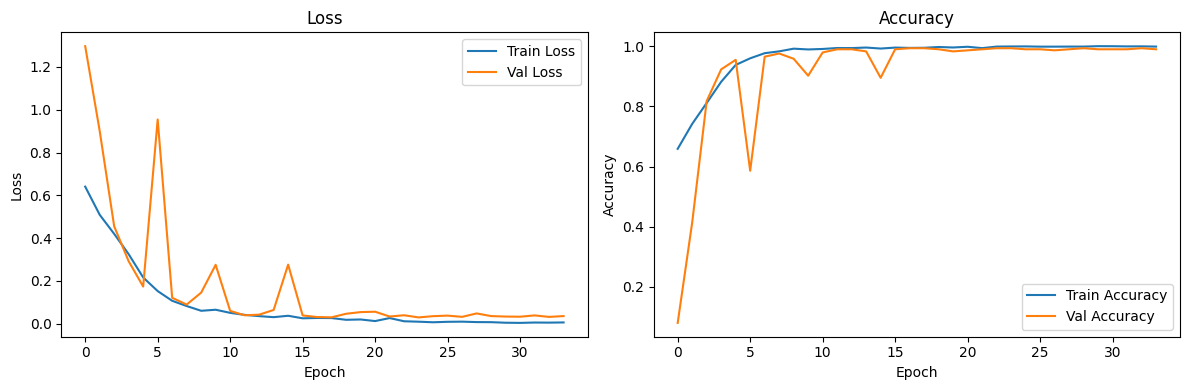

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


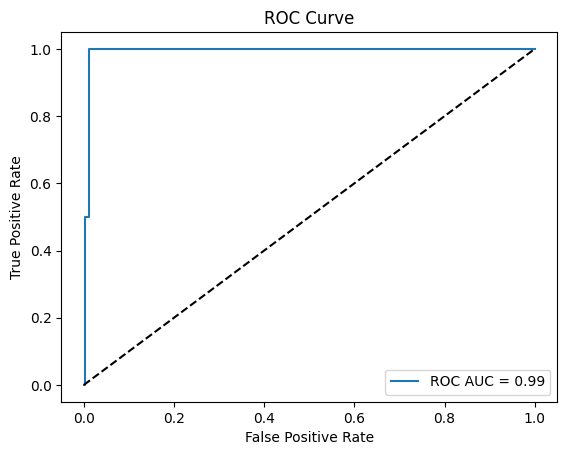

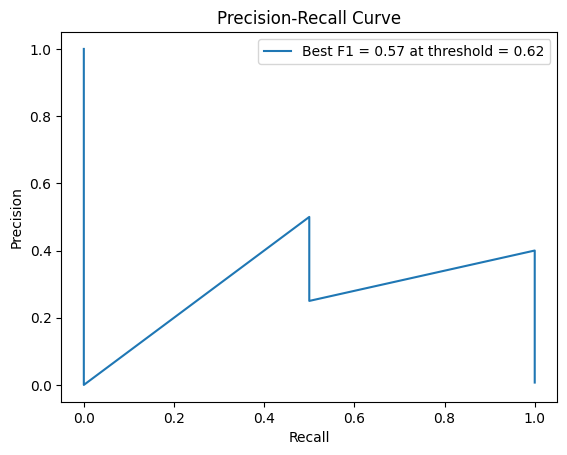

2025-05-28 09:51:38,000 - INFO - Found 3 false positive examples


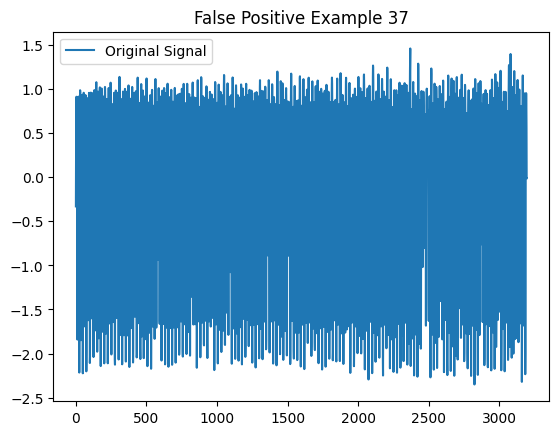

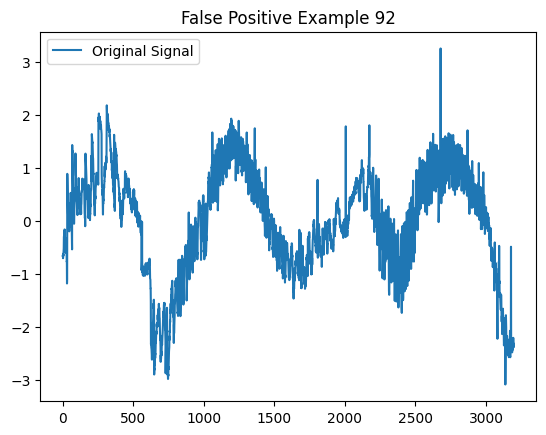

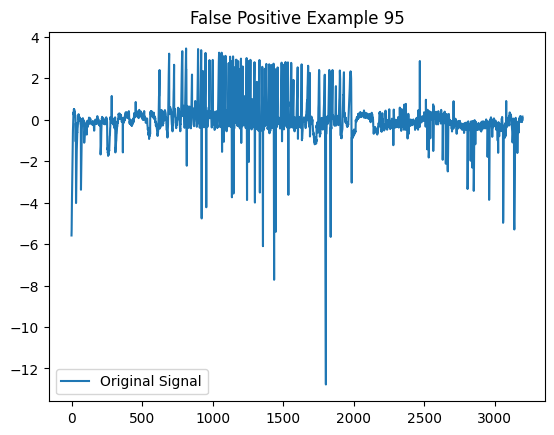

2025-05-28 09:51:38,151 - INFO - Final metrics: AUC=0.99, F1=0.57, Threshold=0.62


In [8]:
def main():
    # Data paths
    train_path = '/Users/ivankanev/Desktop/Uni/1Kandidat/1. År/Blok 4/AML/AML2025_FinalProject/Ivan/exoTrain.csv'
    test_path = '/Users/ivankanev/Desktop/Uni/1Kandidat/1. År/Blok 4/AML/AML2025_FinalProject/Ivan/exoTest.csv'

    # Load data
    x_train, y_train, x_test, y_test = load_data(train_path, test_path)

    # Preprocessing
    x_train, x_test = preprocess_data(x_train, x_test, smoothing_windows=[50, 200])

    # Build model
    model = build_model(input_shape=x_train.shape[1:])
    model.summary()

    # Training
    history, x_test, y_test = train_model(model, x_train, y_train, x_test, y_test)

    # Evaluation
    auc_score, best_f1, best_threshold = evaluate_model(model, x_test, y_test, history)

    logger.info(f"Final metrics: AUC={auc_score:.2f}, F1={best_f1:.2f}, Threshold={best_threshold:.2f}")

if __name__ == "__main__":
    main()

In [9]:
import pandas as pd

# Load the dataset
df = pd.read_csv('exoTrain.csv')

print(df.head())


   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.42       5.08  